In [1]:
import numpy as np
import rescomp as rc
import rescomp.optimizer as rcopt
import findiff as fd

from matplotlib import pyplot as plt

from scipy.io import loadmat
from importlib import import_module

try:
    import importlib.resources as il_resources
except ImportError:
    import importlib_resources as il_resources

In [2]:
BIG_ROBO_DATA = "bellows_arm1_whitened.mat"
SMALL_ROBO_DATA = "bellows_arm_whitened.mat"

class SplitSoftRobotSystem(rcopt.System):
    """
    Class that implements the soft robot system, with constant parts removed from training signal. TODO actually make it do that
    """
    def __init__(self, train_time, test_time, dt, Utol=5e-2, Dtol=1e-7, minlen=5):
        super().__init__('softrobot', train_time, test_time, dt, 6, 6, is_diffeq=False, is_driven=True)
        self.large_data = SplitSoftRobotSystem._load_robo(BIG_ROBO_DATA)
        self.small_data = SplitSoftRobotSystem._load_robo(SMALL_ROBO_DATA)
        self.Utol = Utol
        self.Dtol = Dtol
        self.minlen = minlen
    
    def _load_robo(filename):
        """Load soft robot data"""
        with il_resources.open_binary('rescomp.optimizer.data', filename) as file:
            data = loadmat(file)
        t = data['t'][0]
        q = data['q']
        pref = data["pref"]
        return t, q, pref   
    
    def remove_constant_part(self, t, U, D):
        """Remove constant parts from a (training) signal, using the parameters specified in the object.
        Returns three lists of [ti], [Ui], [Di].
        """
        diff = fd.FinDiff(0, np.mean(np.diff(t)), acc=6)
        dU = diff(U)
        dD = diff(D)
        mask = np.any((np.abs(dU) > self.Utol)
                        + (np.abs(dD) > self.Dtol), axis=1)
        endlist = []
        start = 0
        end = 0
        
        while np.any(mask[start:]):
            start = end + np.argmax(mask[end:])
            end = start + np.argmin(mask[start:])
            if end == start:
                end = -1
            endlist.append((start,end))
            if end == -1:
                break
        return [t[i:j] for i,j in endlist], [U[i:j] for i,j in endlist], [D[i:j] for i,j in endlist]
        
    def get_train_test_data(self, cont_test=False):
        t, U, D = self.large_data
        
        train_steps = int(self.train_time / self.dt)
        test_steps = int(self.test_time / self.dt)
        timesteps = train_steps + test_steps
        
        t, U, D = rcopt.random_slice(t, U, D, timesteps)
        
        tr, ts = t[:train_steps], t[train_steps:]
        Utr, Uts = U[:train_steps, :], U[train_steps:, :]
        Dtr, Dts = D[:train_steps, :], D[train_steps:, :]
        
        if not cont_test:
            t, U, D = self.small_data
            #Make sure the slice isn't too large
            test_steps = min(test_steps,len(t))
            ts, Uts, Dts = rcopt.random_slice(t, U, D, test_steps)
            
        tr, Utr, Dtr = self.remove_constant_part(tr, Utr, Dtr)
        
        return tr, (Utr, Dtr), (ts, Dts), Uts
    
    def get_random_test(self):
        t, U, D = self.small_data
        
        test_steps = int(self.test_time / self.dt)
        test_steps = min(test_steps,len(t))
        
        ts, Uts, Dts = rcopt.random_slice(t, U, D, test_steps)
        return (ts, Dts), Uts
    
def plot_colored(t, Y, colors, start_dot=False, axis=plt, **plot_params):
    """Plots multiple series stored in Y against time, with each series having a different color.
    Parameters:
        t: ((n,) ndarray) time values
        Y: ((n,m) ndarray) sequence values
        colors: (list of m colors)
        start_dot: (default False) - if True, plots a dot at the start of the line, for emphasis
        axis: pyplot module or axis object; used to plot
    """
    for row, c in zip(Y.T,colors):
        axis.plot(t, row, color=c, **plot_params)
    if start_dot:
        axis.scatter([t[0]]*Y.shape[1], Y[0,:],c=colors, **plot_params)

In [3]:
data = SplitSoftRobotSystem._load_robo(BIG_ROBO_DATA)

In [4]:
t, U, D = data
diff = fd.FinDiff(0, np.mean(np.diff(t)), acc=6)
dU = diff(U)
dD = diff(D)

In [41]:
np.any((np.abs(dU[1000:1008,:]) > 1.2e-1) + (np.abs(dD[1000:1008,:]) > 1e-7), axis=1)

array([ True,  True,  True,  True,  True,  True,  True,  True])

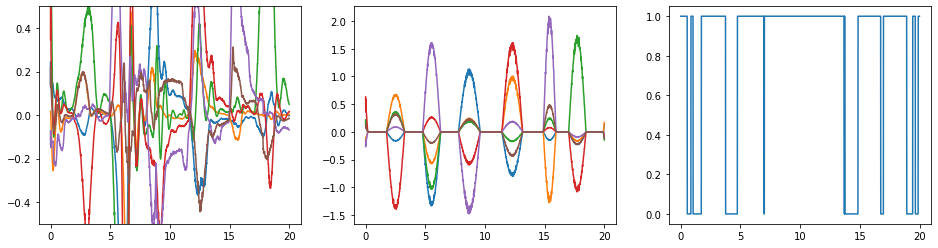

In [45]:
low, width = 0, 2000

fig, ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(t[low:low+width], dU[low:low+width])
ax[0].axis((None,None,-.5,.5))
ax[1].plot(t[low:low+width], dD[low:low+width])
ax[2].plot(t[low:low+width],np.any((np.abs(dU[low:low+width]) > 1.5e-1) + (np.abs(dD[low:low+width]) > 1e-7), axis=1))
plt.show()

In [5]:
rcrunner = rcopt.ResCompOptimizer(SplitSoftRobotSystem(165,20,0.01), 'activ_f', 'continue', 'augmented')

cont_params = {'sigma': 0.6736122617008172, 'gamma': 18.772976319840613, 'ridge_alpha': 0.21859762078674633, 'spect_rad': 1.1638357483638153, 'mean_degree': 2.4119449028157924, 'window': 4.174365541574115, 'overlap': 0.3, 'delta': 0.39215464897158864}
rand_params = {'sigma': 5.0, 'gamma': 0.1, 'ridge_alpha': 2.0, 'spect_rad': 25.0, 'mean_degree': 0.1, 'window': 0.1, 'overlap': 0.0, 'delta': 0.01}

In [6]:
small_data = SplitSoftRobotSystem._load_robo(SMALL_ROBO_DATA)
SplitSoftRobotSystem(165,20,0.01).remove_constant_part(*small_data)

([array([0.        , 0.01000175, 0.0200035 , 0.03000524, 0.04000699,
         0.05000874, 0.06001049, 0.07001223, 0.08001398, 0.09001573,
         0.10001748, 0.11001923, 0.12002097, 0.13002272, 0.14002447,
         0.15002622, 0.16002796, 0.17002971, 0.18003146, 0.19003321,
         0.20003496, 0.2100367 , 0.22003845, 0.2300402 , 0.24004195,
         0.25004369, 0.26004544, 0.27004719, 0.28004894, 0.29005069,
         0.30005243, 0.31005418, 0.32005593, 0.33005768, 0.34005942,
         0.35006117, 0.36006292, 0.37006467, 0.38006642, 0.39006816,
         0.40006991, 0.41007166, 0.42007341, 0.43007515, 0.4400769 ,
         0.45007865, 0.4600804 , 0.47008215, 0.48008389, 0.49008564,
         0.50008739, 0.51008914, 0.52009088, 0.53009263, 0.54009438,
         0.55009613, 0.56009788, 0.57009962, 0.58010137, 0.59010312,
         0.60010487, 0.61010661, 0.62010836, 0.63011011, 0.64011186,
         0.65011361, 0.66011535, 0.6701171 , 0.68011885, 0.6901206 ,
         0.70012234, 0.71012409, 0

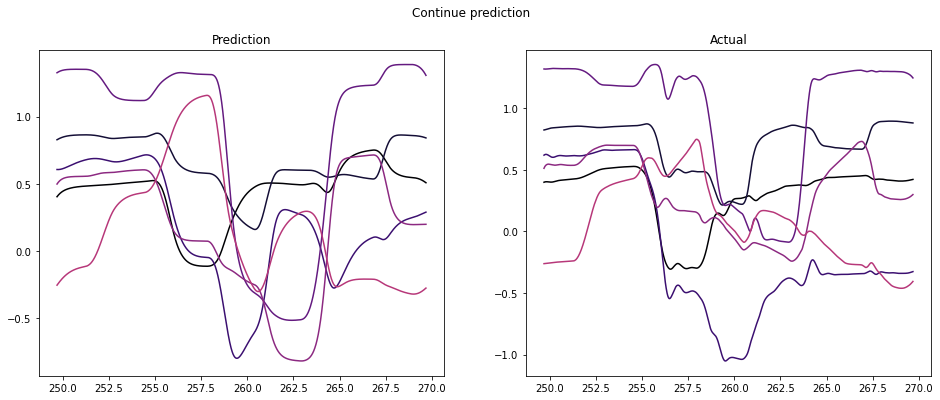

In [9]:
#Continue
rcrunner.prediction_type = 'continue'
tr, (Utr, Dtr), (ts, Dts), Uts, pre = rcrunner.generate_orbits(1, cont_params)[0]

colors = plt.get_cmap('hsv')(np.linspace(0,0.8,6))

fig, ax = plt.subplots(1,2,figsize=(16,6))
plot_colored(ts, pre, colors, axis=ax[0])
ax[0].set_title('Prediction')

plot_colored(ts, Uts, colors, axis=ax[1])
ax[1].set_title('Actual')

plt.suptitle('Continue prediction')
plt.show()

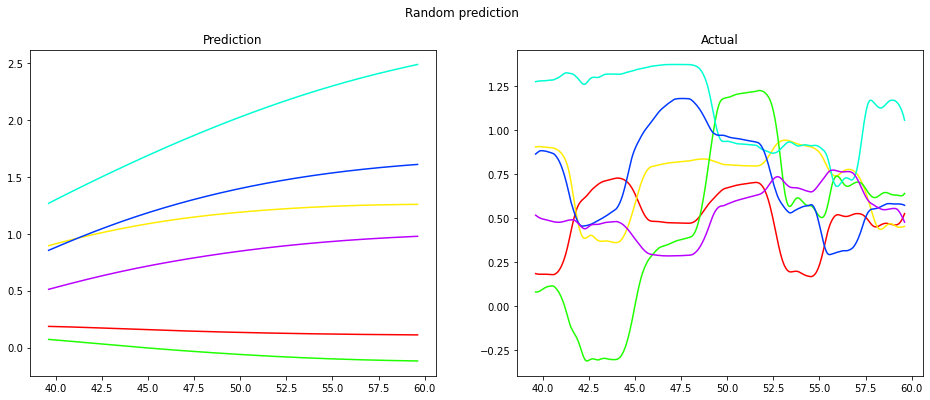

In [11]:
#Random
rcrunner.prediction_type = 'random'
tr, (Utr, Dtr), (ts, Dts), Uts, pre = rcrunner.generate_orbits(1, rand_params)[0]

colors = plt.get_cmap('hsv')(np.linspace(0,0.8,6))

fig, ax = plt.subplots(1,2,figsize=(16,6))
plot_colored(ts, pre, colors, axis=ax[0])
ax[0].set_title('Prediction')

plot_colored(ts, Uts, colors, axis=ax[1])
ax[1].set_title('Actual')

plt.suptitle('Random prediction')
plt.show()

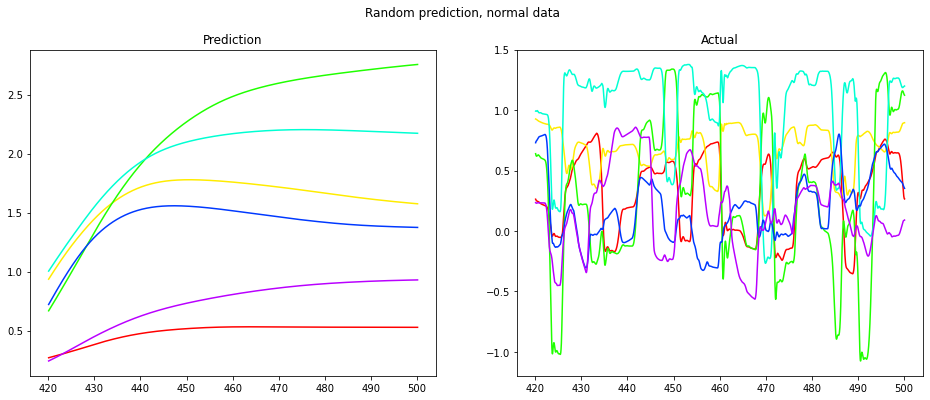

In [13]:
tr, (Utr, Dtr), (ts, Dts), Uts, pre = rcopt.ResCompOptimizer('softrobot','activ_f', 'continue', 'augmented').generate_orbits(1, rand_params)[0]

colors = plt.get_cmap('hsv')(np.linspace(0,0.8,6))

fig, ax = plt.subplots(1,2,figsize=(16,6))
plot_colored(ts, pre, colors, axis=ax[0])
ax[0].set_title('Prediction')

plot_colored(ts, Uts, colors, axis=ax[1])
ax[1].set_title('Actual')

plt.suptitle('Random prediction, normal data')
plt.show()